# Trabajo Práctico Final

# Grupo 10
### Integrantes:
- Facundo Peloso
- Eduardo Barbas
- Roberto Biancardi 
- Juan Pablo Anselmo 
- Matias De Bernardis 

El objetivo de este trabajo práctico es implementar un modelo que pueda predecir el resultado de una partida de ajedrez.

Para entrenar dicho modelo utilizaremos un dataset proporcionado por el sitio Chess.com donde están registradas casi dos millones de partidas desde el 2010 en adelante.

Estos datos describen características de los juegos como la puntuación ELO de los jugadores, con qué piezas jugó cada uno, la apertura seleccionada y la cantidad de movimientos que duró la partida.

## 0. Importación de Módulos y Librerías

In [1]:
#LIBRERÍAS GENERALES
import numpy as np 
import pandas as pd 
import time
pd.set_option('display.max_columns', None) 
import warnings
warnings.filterwarnings("ignore")

# VISUALIZACIÓN
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# PREPROCESAMIENTO
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# PIPELINES
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import set_config
# configuración para mostrar los pipelines de modo grafico
set_config(display=None)


# MODELOS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

#ALMACENAMIENTO OFFLINE
import shelve

## 1. Lectura de Datos Crudos

In [2]:
#Establezco la dirección del archivo
file_location="twic_master.csv"

#Leo el data set usando la librería pandas y se almacena en el objeto Dataframe llamado datos_crudos  
datos_crudos=pd.read_csv(file_location)

In [3]:
print("El tamaño del dataset original es de:")
datos_crudos.shape

El tamaño del dataset original es de:


(1971319, 29)

In [4]:
#Listamos todas las columnas del dataset
datos_crudos.columns

Index(['twic_number', 'White', 'Black', 'Date', 'EventDate', 'Event', 'Result',
       'mainline_moves', 'Site', 'Online', 'Round', 'ECO', 'Opening',
       'WhiteFideId', 'BlackFideId', 'WhiteElo', 'BlackElo', 'Variation',
       'WhiteTitle', 'BlackTitle', 'WhiteTeam', 'BlackTeam', 'EventType',
       'FEN', 'SetUp', 'Variant', 'Board', 'PlyCount', 'EventCategory'],
      dtype='object')

## 2. Preprocesamiento antes del Pipeline

Definimos una función que toma los datos crudos y realiza un preprocesamiento antes de ingresar los datos un pipeline. 

Entre otras cosas: 
- Quita los registros de juegos de Ajedrez 960 (posición de piezas aleatoria).
- Imputa la columna target "Result" en caso de formatos incorrectos. '1-0': Gana Blanca. '0-1': Gana Negra. '1/2-1/2': Empate.
- Se queda con un único tipo de control de tiempo (Blitz: 3 minutos por jugador).
- Filtra outliers según la fecha en que ocurrió el juego.
- Crea la columna cantidad de movimientos.
- Castea formato de algunas columnas.
- Remueve registros con valores nulos en columnas features.

In [5]:
#Funcion para crear la columna cantidad de movimientos
def cant_mov(x):
    if type(x) is str:
        return len(x.replace(" ", "").split('.'))
    else:
        return np.NaN

#Definimos una función que se aplicará sobre cada registro para limpiar resultados
def limpiar_resultado(x):
    if x=='1-0':
        return 0
    elif x=='0-1':
        return 1
    elif x=='1/2-1/2':
        return 2
    else: 
        return np.NaN


#Funcion pre-pipeline(luego implementada con control="blitz" de tiempo para elegir)

def pre_pipeline(X, control):
        #Filtro juegos de 960
        X = X[ (datos_crudos.Variant.isna()) & (datos_crudos.FEN.isna()) & (datos_crudos.SetUp.isna()) ]

        #Ponemos columnas en minuscula
        cols = ['Event', 'Opening', 'Variation', 'EventType']
        for feature in cols:
                X[feature] = X[feature].str.lower().str.strip()

        #Filtro control de tiempo
        X=X[(X.Event.str.contains(control)) | (X.EventType.str.contains(control))]
        
        #Pasamos la columna a Date
        X["Date"] = pd.to_datetime(X["Date"])
        #Filtramos aquellos años que esten dos desvíos standar por debajo de la media
        X=X.loc[X['Date'].dt.year>X['Date'].dt.year.mean()-3*X['Date'].dt.year.std()] 
        
        #FILTRO RESULTADOS MAL CARGADOS
        X = X[(X.Result=="1-0") | (X.Result=="0-1") | (X.Result=="1/2-1/2")]
        #Limpiamos Resultado
        X['Result'] = X['Result'].apply(limpiar_resultado)  

        #PISO "mainline_moves" con el nro de movidas
        X['mainline_moves'] = X['mainline_moves'].apply(cant_mov) 
        
        #ELIMINO registros con nans en Elo ó ID
        X=X.dropna(subset=["WhiteElo","BlackElo","WhiteFideId","BlackFideId"])
        
        #Pasamos los ID a enteros
        X['WhiteFideId'] = pd.to_numeric(X['WhiteFideId']).convert_dtypes() 
        X['BlackFideId'] = pd.to_numeric(X['BlackFideId']).convert_dtypes()

        # Ahora vuelvo los IDs a str, ya que luego les haré ohe
        X.WhiteFideId = X.WhiteFideId.astype(str)
        X.BlackFideId = X.BlackFideId.astype(str)

        # Y los Elos los paso a enteros
        X.WhiteElo = X.WhiteElo.astype(int)
        X.BlackElo = X.BlackElo.astype(int)

        #Quitamos registros nulos en columna de movimientos y aperturas
        X=X.dropna(subset=["mainline_moves","Opening"])

        return X

Usamos la función para crear un dataframe con los datos de los juegos blitz:

In [6]:
df_bz=pre_pipeline(datos_crudos, "blitz")

El tamaño del dataset que usaremos en el pipeline es de aproximadamente 90 mil registros:

In [10]:
print(df_bz.shape)

(89800, 29)


## 3. Separamos datos en Train y Test
Implementamos una función que tomen el dataframe, indique features y target y luego realiza separe en datos de entrenamiento y de testeo.

In [8]:
def tts(dfr):
  # Separemos features y target
  y = dfr.Result
  X = dfr.drop(["Result"],axis=1)

  # Hagamos un split en blitz:
  return train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
  # a la funcion la llamamos igual que a un tr_ts_split, pero con el dfr con features y target de argumento

In [9]:
#Invocamos la función para separar los datos
X_train_bz, X_test_bz, y_train_bz, y_test_bz = tts(df_bz)

## 4. Pipeline

### 4.1 Definimos Transformadores 

Mediante cuatro transformadores eliminamos columnas inncesarias, imputamos valores en columnas claves, generamos variables dummies en las columnas de aperturas e IDs de Blanca y Negra con una mínima frecuencia establecida y escalamos las variables numéricas. 

In [11]:
#Tranformador 1 para eliminar columnas
T1 = ColumnTransformer([('drop', "drop", ['twic_number', 'White', 'Black', 'Date', 'EventDate', 'Event',
                                          'Site', 'Online', 'Round', 'ECO', 'Variation','WhiteTitle',
                                          'BlackTitle', 'WhiteTeam', 'BlackTeam', 'EventType','FEN',
                                          'SetUp', 'Variant', 'Board', 'PlyCount', 'EventCategory'])], remainder = "passthrough")

#Tranformador 2 para imputar columnas
T2 = ColumnTransformer(
[('imputa_movidas', SimpleImputer(strategy='mean'), [0]),
('imputa_apertura', SimpleImputer(strategy='most_frequent'), [1])],
remainder='passthrough')

#Tranformador 3 para generar dummies
T3 = ColumnTransformer(
[('ohe_ids', OneHotEncoder(min_frequency=200, handle_unknown='infrequent_if_exist', sparse_output=False), [2,3]),
('ohe_apertura', OneHotEncoder(min_frequency=2000, handle_unknown='infrequent_if_exist', sparse_output=False), [1])],
remainder = 'passthrough')

#Tranformador 4 para escalar
T4 = ColumnTransformer([('escaleo', MinMaxScaler(), [-1, -2, -3])], remainder = "passthrough")

#Definimos un arbol como clasificador para instanciar el pipeline
arbol = DecisionTreeClassifier(max_depth=7)

#lista de pasos
pasitos = [('T1', T1), ('T2', T2), ('T3', T3), ('T4', T4), ('clf', arbol)]
#instanciamos pipeline
pipe = Pipeline(pasitos)

### 4.2 GridSearch + Pipeline 
#### Definimos mejor con modelo con mejores hiperparámetros

In [12]:
# Instanciamos distintos modelos
log_reg = LogisticRegression()
nb = BernoulliNB()
knn = KNeighborsClassifier()
svm = SVC()
mlp = MLPClassifier(max_iter=500)
dt = DecisionTreeClassifier()
et = ExtraTreesClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()

# Diccionario de modelos con los distintos hiperparámetros para probar
parametros = [
    {'clf': [log_reg], 'clf__C': [0.01, 0.1, 1,2, 5, 10]},
    {'clf': [rf], 'clf__n_estimators': [50, 100, 200]},
    {'clf': [dt], 'clf__max_depth': [6, 7, 8, 9, 10]},
    {'clf': [nb]},
    {'clf': [mlp]},
    {'clf': [knn], 'clf__n_neighbors': [70, 100, 130, 160]},
    {'clf': [xgb], 'clf__colsample_bytree': [0.2, 0.4], 'clf__max_depth': [2, 3, 4, 5]}]

#Definimos la validación cruzada
folds = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)
#Instanciamos GridSearch
search = GridSearchCV(pipe, parametros, cv=folds, scoring="f1_micro", n_jobs=-1)

Entrenamos el gridsearch:

In [13]:
ini = time.time()
search.fit(X_train_bz, y_train_bz)
fin = time.time()
print(f"Entrenar el GridSearch+Pipeline llevo {(fin-ini)/60} minutos de optimización")

Entrenar el GridSearch+Pipeline llevo 2.3596975406010947 minutos de optimización


El mejor modelo fue:

In [14]:
search.best_params_

{'clf': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.4, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...),
 'clf__colsample_bytree': 0.4,
 'clf__max_depth': 3}

Vemos el score de todos los modelos:

In [15]:
res = pd.DataFrame(search.cv_results_).sort_values(by = "rank_test_score").set_index("rank_test_score").loc[:,["params","mean_test_score"]]
res

,params,mean_test_score
rank_test_score,,
1,"{'clf': XGBClassifier(base_score=None, booster...",0.595448
2,"{'clf': XGBClassifier(base_score=None, booster...",0.594933
3,"{'clf': XGBClassifier(base_score=None, booster...",0.593889
4,"{'clf': XGBClassifier(base_score=None, booster...",0.592943
5,{'clf': MLPClassifier(max_iter=500)},0.592163
6,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.591787
7,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.591439
8,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.589992
9,"{'clf': XGBClassifier(base_score=None, booster...",0.589504


## 5. Predecimos con el mejor modelo

In [16]:
y_pred_search_bz = search.predict(X_test_bz)

accuracy_score(y_test_bz, y_pred_search_bz)

0.6025612472160357

## 5.1 Visualizamos la performance del mejor modelo

In [17]:
# Esta funcion toma los sets (X_test, y_test) y la predicción y_pred de un modelo
# Para entregar gráficas y métricas de score
def GRAFICAS(X_test, y_test, y_pred):
    
    y_test = pd.Series(y_test)
    y_pred = pd.Series(y_pred, index=y_test.index)
    
    c = confusion_matrix(y_test, y_pred) # mostramos la matriz de confusion
    plt.figure(figsize=(4  ,4))
    ax= plt.subplot()
    sns.heatmap(c, cmap="coolwarm", annot=True, fmt="d")
    ax.set_xlabel('Resultados predecidos')
    ax.set_ylabel('Resultados del test')
    ax.xaxis.set_ticklabels(['B(0)', 'N(1)', "T(2)"])
    ax.yaxis.set_ticklabels(['B(0)', 'N(1)', "T(2)"])
    ax.set_title('Matriz de Confusión')
    plt.show()
    
    print(f"El accuracy global del modelo es {accuracy_score(y_test, y_pred)}.")

    # Me armo un df de scores para cada resultado
    scores = pd.DataFrame({"Resultado":range(3),
                         "sensibilidad":pd.Series(recall_score(y_test, y_pred, average=None)),
                         "precisión":pd.Series(precision_score(y_test, y_pred, average=None)),
                         "f1":pd.Series(f1_score(y_test, y_pred, average=None))})
    scores.index.name='Resultado'
    print(f"\n\nEstos son los scores para cada resultado")

    display(scores.loc[:,"sensibilidad":].transpose().round(3))

    # hacemos un melt sobre Resultados para graficar
    df = scores.melt("Resultado", var_name='scores', value_name='Scores')
    # graficamos los scores para cada resultado
    sns.catplot(x="Resultado", y="Scores", hue='scores', data=df, kind='point')
    #plt.savefig(f"tp3_{type(modelo)}.png")
    plt.show()

    # Mostremos los errores cometidos
    err = y_test != y_pred # Hacemos una mascara de errores

    print(f"\n\nEstos son los errores de sensado (resultado mal identificado) y los errores de presición (resultado mal asignado):") 

    err1 = pd.DataFrame({"Mal sensado":y_test[err].value_counts(), "Mal predecido":y_pred[err].value_counts()})
    tot1 = err1["Mal sensado"].sum()
    tot2 = err1["Mal predecido"].sum()
    err1.loc["Total"] = [tot1,tot2]
    err1.index.name='Resultado'
    display(err1.transpose())

    # Un dataframe de errores:
    errores = pd.DataFrame({"y_test":y_test[err], "y_pred":y_pred[err]})
    errores["frecuencia"] = errores.apply(lambda x: c[x.y_test,x.y_pred] ,axis=1)
    errores = errores.sort_values(by=["frecuencia",'y_test', 'y_pred'],ascending=[False,False,False])

    print(f"\n\nAquí se muestra la frecuencia de cada uno de los {errores.shape[0]} errores cometidos:")
    display (errores.drop_duplicates().set_index('frecuencia').transpose())

    # Y para finalizar graficamos los errores de predicción, con la perspectiva puesta en Los Elos, que son nuestros
    # mejores predictores
    X_test["Errores de Sensibilidad"] = y_test
        
    X_test["Errores de Precisión"] = y_pred
    
    print("\n\nEstos son los errores de recall (etiquetas del test mal predecidas):")
    sns.pairplot(X_test[err], vars=['WhiteElo', 'BlackElo'], hue = "Errores de Sensibilidad", plot_kws={"s": 1}, palette="Dark2")
    plt.show()

    # Acá se va a ver cómo los modelos predicen empates sólo para los jugadores de mayor Elo.
    print("\n\nEstos son los errores de precisión (predicciones erróneas del modelo):")
    sns.pairplot(X_test[err], vars=['WhiteElo', 'BlackElo'], hue = "Errores de Precisión", plot_kws={"s": 1}, palette="Dark2")
    plt.show()
    print("Los errores de precisión a su vez revelan las fronteras de decisión del modelo")
    
    
    # Y un poco mas en detalle el tipo de error:
    X_err = X_test.loc[err]
    X_err["(Test, Pred)"] = X_err.apply(lambda x: (x["Errores de Sensibilidad"], x["Errores de Precisión"]), axis=1)
    
    print("\n\nAquí se grafican los seis tipos de errores posibles:")
    sns.pairplot(X_err, vars=['WhiteElo', 'BlackElo'], hue = "(Test, Pred)", plot_kws={"s": 1}, palette="Paired")
    plt.show()

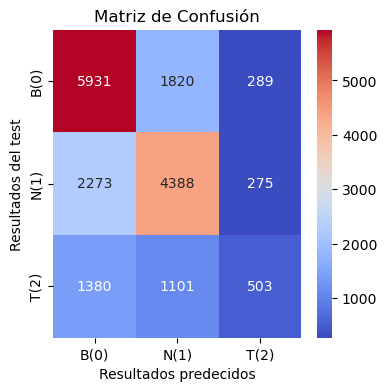

El accuracy global del modelo es 0.6025612472160357.


Estos son los scores para cada resultado


Resultado,0,1,2
sensibilidad,0.738,0.633,0.169
precisión,0.619,0.600,0.471
f1,0.673,0.616,0.248


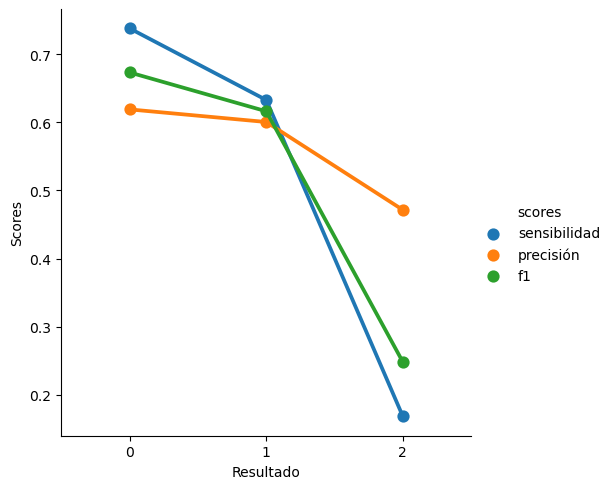



Estos son los errores de sensado (resultado mal identificado) y los errores de presición (resultado mal asignado):


Resultado,0,1,2,Total
Mal sensado,2109,2548,2481,7138
Mal predecido,3653,2921,564,7138




Aquí se muestra la frecuencia de cada uno de los 7138 errores cometidos:


frecuencia,2273,1820,1380,1101,289,275
y_test,1,0,2,2,0,1
y_pred,0,1,0,1,2,2




Estos son los errores de recall (etiquetas del test mal predecidas):


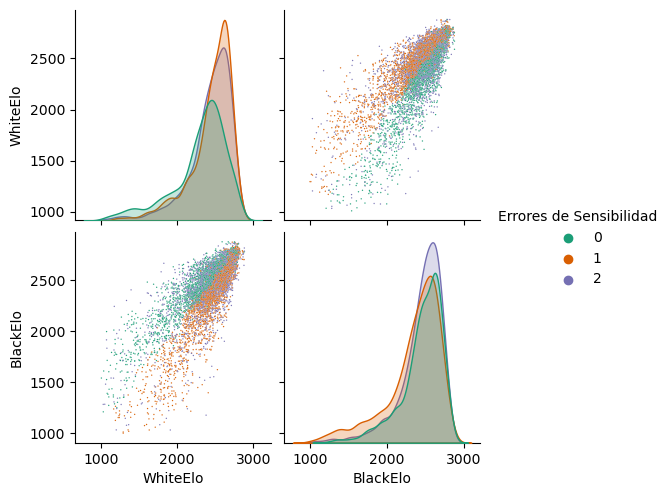



Estos son los errores de precisión (predicciones erróneas del modelo):


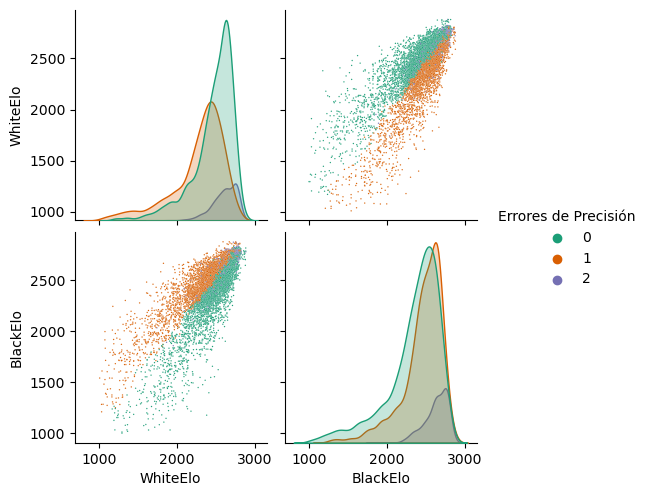

Los errores de precisión a su vez revelan las fronteras de decisión del modelo


Aquí se grafican los seis tipos de errores posibles:


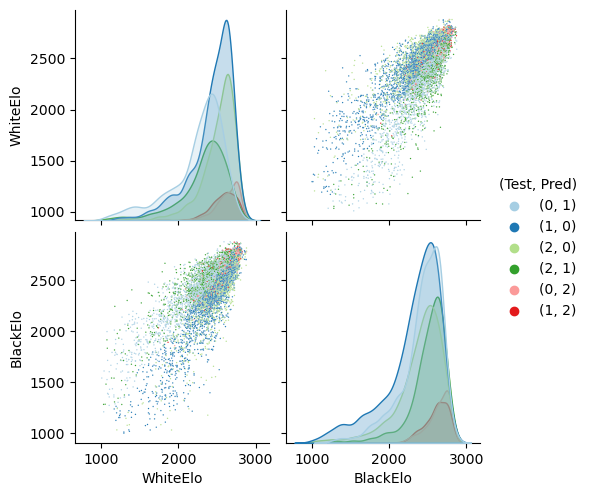

In [18]:
GRAFICAS(X_test_bz, y_test_bz, y_pred_search_bz)

## 6. Refinamos el mejor modelo con hiperparámetros del mismo y de los transformadores

In [19]:
#pongamos al xgb como clasificador:
pasitos[4] = ("clf", xgb)
pipe = Pipeline(pasitos)

In [20]:
# Defino parámetros a probar del modelo y de los transformadores
parametros_xgb = [
    {
     'clf': [xgb],
     'clf__colsample_bytree': [0.4, 0.6],
     'clf__max_depth': [3, 4],
     'clf__n_estimators': [400],
     'clf__learning_rate': [0.1, 0.15],
     'T3__ohe_ids__min_frequency': [100,200], # acá me meto en los hiperparámetros del preprocesamiento
     'T3__ohe_apertura__min_frequency': [2000,3000] # va ha probar con dummies para los jugadores que aparece más de 100, 200 ... veces
     # va a probar con dummies para las aperturas que aparecen más de 2000, 3000 ... veces
     
     }]

folds = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)
search_xgb = GridSearchCV(pipe, parametros_xgb, cv=folds, scoring="f1_micro", n_jobs=-1)

Entrenamos el modelo refinado:

In [21]:
ini = time.time()
search_xgb.fit(X_train_bz, y_train_bz)
fin = time.time()
print(f"Entrenar el modelo refinado llevo{(fin-ini)/60} minutos de optimización")


Entrenar el modelo refinado llevo12.743409140904744 minutos de optimización


Vemos los mejores 5 resultados:

In [22]:
pd.DataFrame(search_xgb.cv_results_).sort_values(by="mean_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_T3__ohe_apertura__min_frequency,param_T3__ohe_ids__min_frequency,param_clf,param_clf__colsample_bytree,param_clf__learning_rate,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
27,19.690375,0.140625,1.224728,0.002994,3000,200,"XGBClassifier(base_score=None, booster=None, c...",0.4,0.15,4,400,"{'T3__ohe_apertura__min_frequency': 3000, 'T3_...",0.598023,0.589198,0.593611,0.004413,31
11,22.048097,0.514648,1.420204,0.055853,2000,200,"XGBClassifier(base_score=None, booster=None, c...",0.4,0.15,4,400,"{'T3__ohe_apertura__min_frequency': 2000, 'T3_...",0.598023,0.589198,0.593611,0.004413,31
15,26.602404,0.042387,1.418212,0.003992,2000,200,"XGBClassifier(base_score=None, booster=None, c...",0.6,0.15,4,400,"{'T3__ohe_apertura__min_frequency': 2000, 'T3_...",0.597077,0.590924,0.594001,0.003076,29
31,24.904940,1.373828,1.196802,0.140624,3000,200,"XGBClassifier(base_score=None, booster=None, c...",0.6,0.15,4,400,"{'T3__ohe_apertura__min_frequency': 3000, 'T3_...",0.597077,0.590924,0.594001,0.003076,29
19,45.691887,1.325458,2.096397,0.191488,3000,100,"XGBClassifier(base_score=None, booster=None, c...",0.4,0.15,4,400,"{'T3__ohe_apertura__min_frequency': 3000, 'T3_...",0.596743,0.591871,0.594307,0.002436,27


Realizamos la predicción nuevamente:

In [23]:
y_search_xgb_bz = search_xgb.predict(X_test_bz)

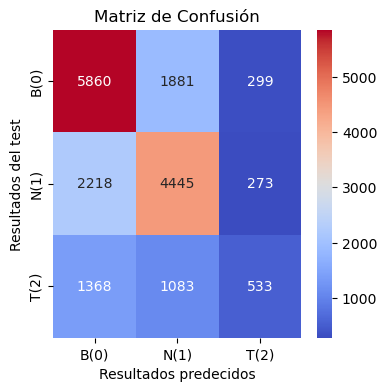

El accuracy global del modelo es 0.6034521158129176.


Estos son los scores para cada resultado


Resultado,0,1,2
sensibilidad,0.729,0.641,0.179
precisión,0.620,0.600,0.482
f1,0.670,0.620,0.261


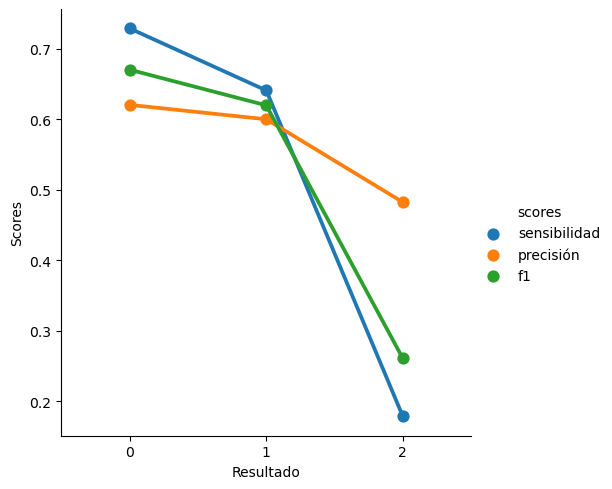



Estos son los errores de sensado (resultado mal identificado) y los errores de presición (resultado mal asignado):


Resultado,0,1,2,Total
Mal sensado,2180,2491,2451,7122
Mal predecido,3586,2964,572,7122




Aquí se muestra la frecuencia de cada uno de los 7122 errores cometidos:


frecuencia,2218,1881,1368,1083,299,273
y_test,1,0,2,2,0,1
y_pred,0,1,0,1,2,2




Estos son los errores de recall (etiquetas del test mal predecidas):


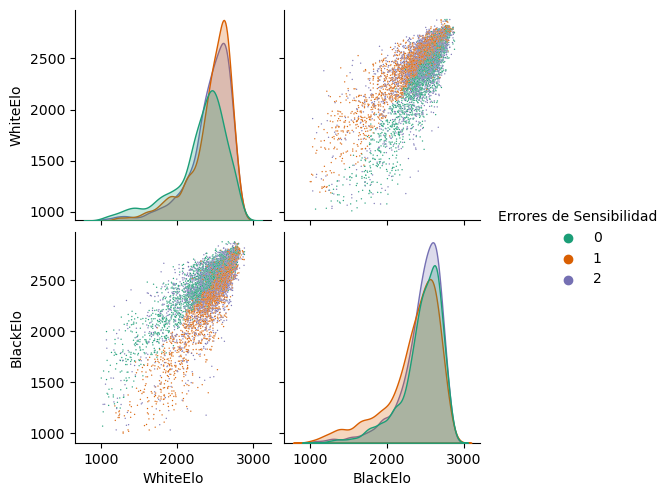



Estos son los errores de precisión (predicciones erróneas del modelo):


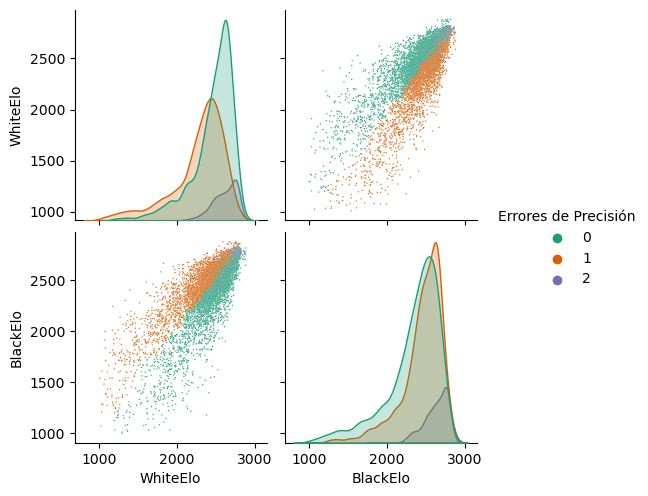

Los errores de precisión a su vez revelan las fronteras de decisión del modelo


Aquí se grafican los seis tipos de errores posibles:


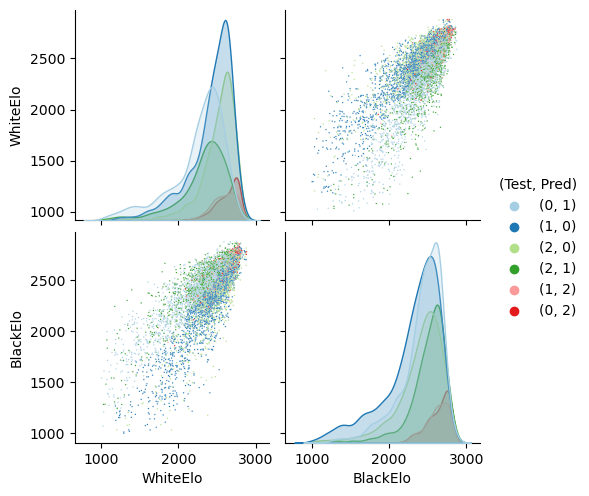

In [24]:
GRAFICAS(X_test_bz, y_test_bz, y_search_xgb_bz)

## 7. Almacenamos modelo entrenado 

In [25]:
models = shelve.open('modelos.db')

models['xgb']=search_xgb

models.close()